In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#user profiles
user_profile_df = pd.read_csv("user_profile.csv")

#Users we want to give reccomendations to
test_users_df = pd.read_csv('rs_content_test.csv')[['user', 'item']]

# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import string

In [10]:
#Obtain Feature Names and user_ids
feature_names = user_profile_df.columns[1:]
user_ids = user_profile_df['user']

#Initialize StandardScaler
scaler = StandardScaler()

# Normalize the feature vectors
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
X = user_profile_df[feature_names].values

X

array([[ 6.10647396,  2.48538767,  0.96124168, ...,  7.36089876,
         6.3693226 ,  2.57011581],
       [ 4.52998018, -0.35337666,  0.4406526 , ...,  0.8654161 ,
        -0.23162117,  0.51941894],
       [ 2.42798846,  1.06600551,  4.08477616, ...,  5.50504657,
         2.70213161,  2.57011581],
       ...,
       [-0.33087567,  0.59287812,  0.96124168, ..., -0.52647304,
        -0.23162117, -0.5059295 ],
       [-0.72499912, -0.82650404, -0.60052555, ..., -0.52647304,
        -0.23162117, -0.5059295 ],
       [-0.72499912, -0.82650404, -0.60052555, ..., -0.52647304,
        -0.23162117, -0.5059295 ]])

In [11]:

def combine_cluster_labels(user_ids, labels, X):
    """Combine user IDs with cluster labels and calculate the silhouette score.
    
    Args:
        user_ids (DataFrame): A DataFrame containing the user IDs.
        labels (list): A list of cluster labels.
        X (array-like): The data used to generate the cluster labels.
        
    Returns:
        tuple: A tuple containing the cluster DataFrame and silhouette score.
        
    """
    # Combine user IDs with cluster labels
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    
    # Calculate the silhouette score
    score = silhouette_score(X, labels)
    
    return cluster_df, score


def sum_squared_distances(estimator, X):
    """Calculate the sum of squared distances between each point and its assigned cluster center.
    
    Args:
    - estimator: The clustering estimator object.
    - X: The feature matrix.
    
    Returns:
    - The sum of squared distances.
    """
    centers = estimator.cluster_centers_
    cluster_assignments = estimator.predict(X)
    sum_squared_distances = sum(
        np.sum((X[cluster_assignments == i] - centers[i]) ** 2) for i in range(estimator.n_clusters)
    )
    return sum_squared_distances


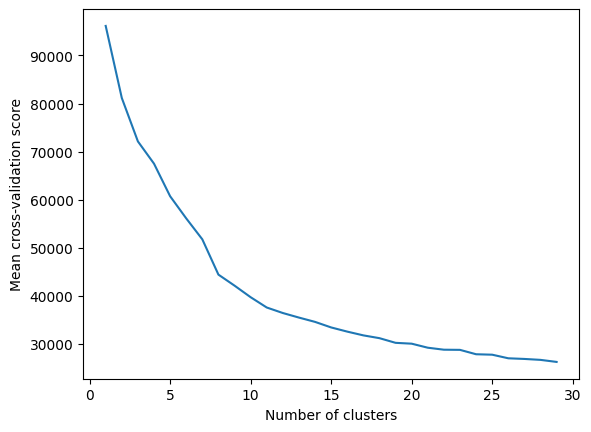

In [12]:
# Create a k-means model
kmeans = KMeans()
# Define the range of clusters to try
param_grid = {'n_clusters': range(1, 30)}

grid_search = GridSearchCV(kmeans, param_grid, scoring=sum_squared_distances, cv=5)
grid_search.fit(X)
results = grid_search.cv_results_
n_clusters = results['param_n_clusters']
mean_scores = results['mean_test_score']

# Plot the mean cross-validation scores for each value of n_clusters
plt.plot(n_clusters, mean_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Mean cross-validation score')
plt.show()

## New Cell
# Get the best number of clusters
best_n_clusters = grid_search.best_params_['n_clusters']
sum_squared_distances = -1 * grid_search.cv_results_['mean_test_score']

# Use the best number of clusters to fit the model
best_kmeans = KMeans(n_clusters=15)
best_kmeans.fit(X)  
cluster_labels = best_kmeans.labels_


# Obtain the clustered dataframe and the score
cluster_df, score = combine_cluster_labels(user_ids, cluster_labels, X)

In [13]:
# Print cluster_df for a quick visual check of the dataframe
cluster_df

,user,cluster
0,2,11
1,4,8
2,5,11
3,7,2
4,8,2
...,...,...
33896,2102054,9
33897,2102356,2
33898,2102680,14
33899,2102983,2


In [14]:

def cluster_item_enrol(cluster_df, test_users_df):
    """Group test users by cluster and count the number of enrollments for each course.
    
    Args:
    cluster_df (pandas.DataFrame): A DataFrame with user and cluster columns.
    test_users_df (pandas.DataFrame): A DataFrame with user and item columns.

    Returns:
    tuple: A tuple containing the following two DataFrames:
        - cluster_item_enrol_df (pandas.DataFrame): A DataFrame with columns cluster, item and enrollments.
        - test_users_labelled (pandas.DataFrame): A DataFrame with columns user, item and cluster.
    """
    #Merge the test_df with the cluster_df to assign cluster label to test user
    test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')

    #Enrollments count for each course in each group
    courses_cluster = test_users_labelled[['item', 'cluster']]
    courses_cluster['count'] = [1] * len(courses_cluster)
    cluster_item_enrol_df = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
    return cluster_item_enrol_df, test_users_labelled



In [15]:
cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)

In [16]:

def results_dict_function(cluster_item_enrol_df, test_users_df):
    """
    Generate a dictionary of recommendation results for each test user, including a dataframe of all recommended courses,
    the average number of recommendations per user, a list of the number of recommendations for each user, and a 
    dataframe of the top 10 most frequently recommended courses.
    
    Args:
    - cluster_item_enrol_df (pandas.DataFrame): A dataframe containing the cluster, item, and enrollments columns
        for each course.
    - test_users_df (pandas.DataFrame): A dataframe containing the user and item columns for each test user.
    
    Returns:
    - results_dict (dict): A dictionary containing the following keys:
        - 'all_recommendations_df': A dataframe containing all recommended courses for all test users.
        - 'average_num_recommendations': The average number of recommendations per test user.
        - 'user_mean_recommendations': A list of the number of recommendations for each test user.
        - 'top_10_courses': A dataframe of the top 10 most frequently recommended courses.
    """
    
    # Set threshold
    enrollment_count_threshold = 10

    # Filter courses with an enrollment count larger than the threshold
    popular_courses_df = cluster_item_enrol_df[cluster_item_enrol_df['enrollments'] > enrollment_count_threshold]

    # Find courses not taken by test user
    unseen_courses = popular_courses_df[~popular_courses_df['item'].isin(test_users_labelled)]

    # Group the merged DataFrame by the user column and get the list of courses taken by each test user
    test_user_courses = pd.merge(test_users_labelled, cluster_item_enrol_df, on=['cluster', 'item']).groupby('user')['item'].apply(list).to_dict()

    # Initialize a dictionary to store the recommendation results for each test user
    recommendation_results = {}

    # Loop through the test users
    for user, cluster in test_users_labelled[['user', 'cluster']].values:
        # Filter courses to only include those taken by users in the same cluster as the test user
        filtered_courses_df = popular_courses_df[popular_courses_df['cluster'] == cluster]

        # Get the list of courses taken by the test user or an empty list if the user is not found
        test_user_courses_list = test_user_courses.get(user, [])

        # Find courses in filtered dataframe not taken by the test user
        recommendations = filtered_courses_df[filtered_courses_df['item'].isin(test_user_courses_list)]

        # Add the recommendation results for the test user to the dictionary
        recommendation_results[user] = recommendations

    # Calculate the mean number of recommendations for each user
    user_mean_recommendations = [len(recommendations) for recommendations in recommendation_results.values()]

    # Calculate the mean of the user_mean_recommendations list
    average_num_recommendations = np.mean(user_mean_recommendations)

    # Concatenate the dataframes in the recommendation_results dictionary into a single dataframe
    all_recommendations_df = pd.concat(recommendation_results.values())

    # Get the top 10 most frequently recommended courses
    top_10_courses = all_recommendations_df['item'].value_counts().head(10).reset_index(name='count').rename(columns={'index': 'item'})

    # Create a dictionary to store the results
    results_dict = {
        "all_recommendations_df": all_recommendations_df,
        "average_num_recommendations": average_num_recommendations,
        "user_mean_recommendations": user_mean_recommendations,
        "top_10_courses": top_10_courses,
    }
    
    return results_dict

In [17]:
results_dict_gridseach = results_dict_function(cluster_item_enrol_df, test_users_df)

In [18]:
#Model 2

#cluster_df_algorithm
#Optimizer: lowest sum of squares,     #Scaler: StandardScaler         #PCA = NO

#cluster_item_enrol
#cluster_df, test_users_df

#reccomend_unseen
#legacy_results_dict = None #hyperparms = 'grid_standard'


# Fit k-means model to find the optimal number of clusters
def lowest_sum_of_squares(X):
    model = KMeans()
    scores = []
    for n_clusters in range(1, 25):
        model.n_clusters = n_clusters
        model.fit(X)
        scores.append(-model.score(X))
    best_n_clusters = np.argmin(scores) + 1
    #model.n_clusters = best_n_clusters
    model.n_clusters = 22
    model.fit(X)
    # Assign cluster labels to each user
    clusters = model.predict(X)
    cluster_labels = model.labels_
    return cluster_labels

cluster_df, score_2 = combine_cluster_labels(user_ids, cluster_labels, X)

# Print cluster_df for a quick visual check of the dataframe
cluster_df

cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)


results_dict_gridseach_2 = results_dict_function(cluster_item_enrol_df, test_users_df)

In [19]:
#Model 3

#cluster_df_algorithm
#Optimizer: gap_statistic,     #Scaler: StandardScaler         #PCA = NO

#cluster_item_enrol
#cluster_df, test_users_df

#reccomend_unseen
#legacy_results_dict = None #hyperparms = 'grid_standard'



def optimize_clusters_gap_statistic(X, n_reference_datasets=10, max_clusters=30):
    #Random seed for reproducibility
    np.random.seed(64)
    # Generate reference datasets
    reference_datasets = [np.random.permutation(X) for _ in range(n_reference_datasets)]

    # Compute the gap statistic for each number of clusters
    gap_statistics = []
    for n_clusters in range(1, max_clusters+1):
        model = KMeans(n_clusters=n_clusters)
        model.fit(X)
        Wk = model.inertia_
        Wk_reference = [model.fit(X_reference).inertia_ for X_reference in reference_datasets]
        gap = np.log(np.mean(Wk_reference)) - np.log(Wk)
        gap_statistics.append(gap)

    # Choose the optimal number of clusters
    best_n_clusters = np.argmax(gap_statistics) + 1
    return best_n_clusters

# Run the Gap statistic optimizer
#best_n_clusters = optimize_clusters_gap_statistic(X)
best_n_clusters = optimize_clusters_gap_statistic(X, n_reference_datasets=10, max_clusters=30)
# Fit k-means model with the optimal number of clusters
model = KMeans(n_clusters=best_n_clusters)
model.fit(X)

# Assign cluster labels to each user
clusters = model.predict(X)
cluster_labels = model.labels_


cluster_df, score_3 = combine_cluster_labels(user_ids, cluster_labels, X)

# Print cluster_df for a quick visual check of the dataframe
cluster_df

cluster_item_enrol_df, test_users_labelled = cluster_item_enrol(cluster_df, test_users_df)


results_dict_gridseach_3 = results_dict_function(cluster_item_enrol_df, test_users_df)

[]

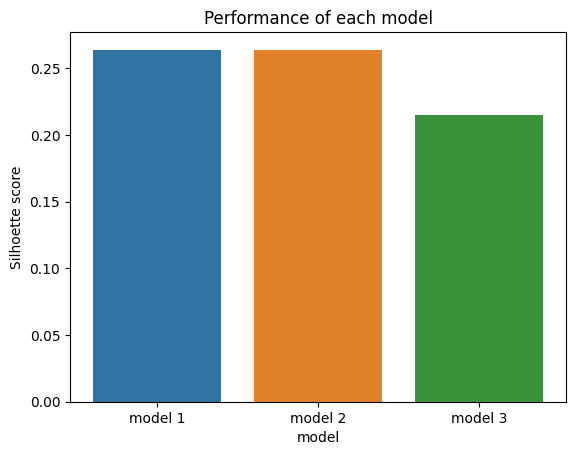

In [20]:
df_list_names = ['model 1', 'model 2', 'model 3']
score_list = [score, score_2, score_3]
# create a dataframe with the values and names
df_results_final = pd.DataFrame({'Silhoette score': score_list, 'model': df_list_names})

# use seaborn to plot the bar chart
sns.barplot(x='model', y='Silhoette score', data=df_results_final)
plt.title('Performance of each model')
plt.plot()